# Exploratory Analysis of parsed data

In [2]:
import os
import pandas as pd

df_articles = pd.read_pickle("../data/processed/parsed_articles.pkl")

<a id="table-of-contents"></a>

## Table of Contents

Overview of parsed data checks to guide data cleaning steps.

1. [High-Level Checks](#data_checks)  
   * Record counts (compared to expectations)
   * Check dates
   * Time distribution plot  

2. [Repeated Headlines](#headlines)  
   * Most frequent headlines  
   * Recurring topics  
   * Quasi-duplicate articles (same headline, similar body)  

3. [Sections Analysis](#sections)  

4. [Potential Issues](#issues)  
   * Working-class keywords review  
   * Data profiling summary


<a id="data_checks"></a>
## 1. High Level Checks 


[⬆ Return to Top](#table-of-contents)

### Record Counts

In [3]:
expected_n_articles = 500 * 86 + 305 + 361
parsed_articles = df_articles.shape[0]

In [4]:
try:
    assert expected_n_articles == parsed_articles, (
        f"Mismatch: expected {expected_n_articles}, got {parsed_articles}"
    )
    print(f"✅ Total number of articles parsed: {parsed_articles} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of articles parsed: 43666 — matches expectations.


In [6]:
expected_n_source_files = 88
parsed_sources_files = len(set(df_articles["source_file"]))

In [7]:
try:
    assert expected_n_source_files == parsed_sources_files, (
        f"Mismatch: expected {expected_n_source_files}, got {parsed_sources_files}"
    )
    print(f"✅ Total number of source files parsed: {parsed_sources_files} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of source files parsed: 88 — matches expectations.


### Check dates

In [13]:
# Check that no date values are missing
missing_dates_count = df_articles['date'].isna().sum()
try:
    assert missing_dates_count == 0, (
        f"Found {missing_dates_count} articles with missing dates:\n"
        f"{df_articles.loc[df_articles['date'].isna()]}"
    )
    print("✅ All articles have a date — expectations met.")
except AssertionError as e:
    print(f"❌ Date check failed. {e}")


✅ All articles have a date — expectations met.


In [10]:
# Validate that all 'date' entries can be parsed into valid dates
try:
    parsed_dates = pd.to_datetime(df_articles["date"], errors="coerce").dt.date
    invalid_dates = df_articles.loc[parsed_dates.isna()]
    invalid_count = invalid_dates.shape[0]

    assert invalid_count == 0, (
        f"Found {invalid_count} articles with invalid or missing dates:\n"
        f"{invalid_dates}"
    )

    print("✅ All articles have valid dates — expectations met.")
except AssertionError as e:
    print(f"❌ Date validation failed. {e}")


✅ All articles have valid dates — expectations met.


In [29]:
print("Number of articles with date at the end: ", 
int(df_articles.apply(lambda x: x['correction_appended'] or x['load_date_at_end'], axis = 1).sum()))

Number of articles with date at the end:  461


### Time Distribution Plot

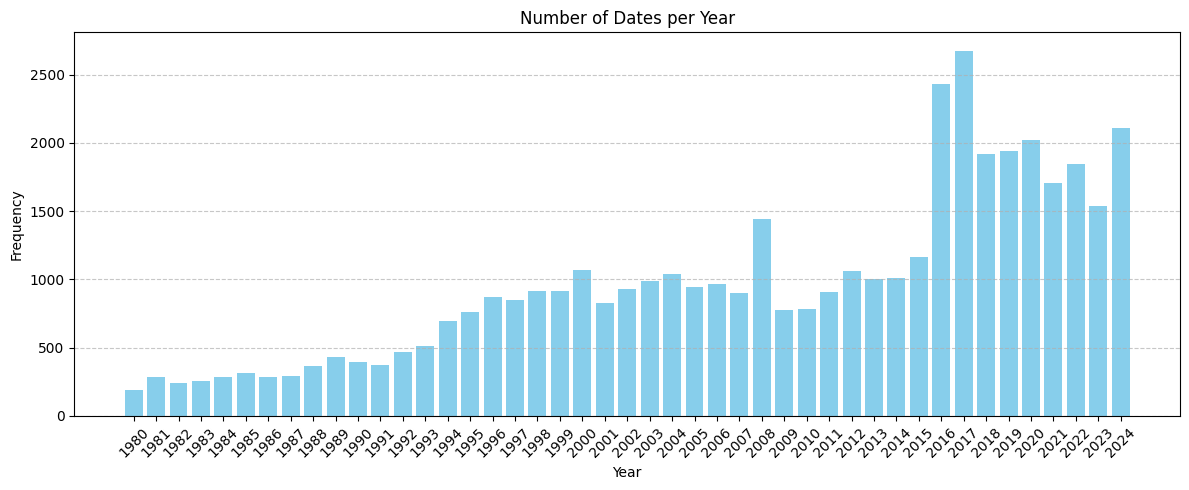

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# Group by year
years = [d.year for d in parsed_dates]
year_counts = Counter(years)

# Sort by year
sorted_years = sorted(year_counts)
frequencies = [year_counts[year] for year in sorted_years]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(sorted_years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Dates per Year')
plt.xticks(sorted_years, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<a id="headlines"></a>
## 2. Reapted Headlines


[⬆ Return to Top](#table-of-contents)

### Most frequent headlines

In [15]:
highest_frequency_titles = {key:value for key, value in dict(df_articles['title'].value_counts()).items() if value > 100}
highest_frequency_titles

{'No Headline In Original': np.int64(368), 'Movie guide': np.int64(101)}

In [16]:
df_no_headline = df_articles.loc[df_articles["title"] == "No Headline In Original"]
df_no_headline.head(2)

title           publisher        date  \
446  No Headline In Original  The New York Times  2024-09-01   
457  No Headline In Original  The New York Times  2022-01-30   

                                               section     length  \
446  Section MB; Column 0; Metropolitan Desk; Pg. 3...  533 words   
457  Section MB; Column 0; Metropolitan Desk; Pg. 3...  774 words   

                                                  body  correction_appended  \
446  \n\nIn the Schools: Dress Codes, Self-Expressi...                False   
457  \n\nHow Fire Defined the Bronx, and Us\nReader...                False   

     load_date_at_end  source_file  
446             False  NYT/55.DOCX  
457             False  NYT/55.DOCX

In [17]:
select_index = 0 # select index to view the body of a different article
print(df_no_headline['body'].iloc[select_index])



In the Schools: Dress Codes, Self-Expression and Inequity
Readers responded by letter and at nytimes.com to Ginia Bellafante's Big City column on Aug. 18 about student dress codes and whether school uniforms should be required. Comments were edited.   I grew up in a working-class family, only ever had thrift store clothes, and was a social pariah because of that. Now my kid attends a New York City charter school where uniforms are required. I love it. The uniform completely removes any sense of ever having the ''wrong'' clothes, which I can attest from personal experience means that a major distraction is just completely removed from the day's equation. There's still some room for personal expression. There are dress, skirt, pants and shorts options, and two possible colors of shirts.
  Emily St. John Mandel, New York
  Every new school year, we grapple with how to make sure that our students are mindful, respectful and safe while maintaining independence and self-expression. This ye

In [19]:
# to view examples from other publishers
select_index = 0
select_publisher = "Chicago Daily Herald"
df_no_headline_select_publisher = df_no_headline.loc[df_no_headline["publisher"] == "Chicago Daily Herald"]
print(df_no_headline_select_publisher['body'].iloc[select_index])



This feeling isn't envy, it's anger
Columnist Ruben Navarette is way out of touch with the average person. His Feb. 26 column on income envy is what is wrong with the path America is heading down.
The sentiment he feels is not envy, but anger. The average working person just wants a fair shake on a level playing field, but the deck is stacked against them.
The wealthy and upper class buy legislation that only benefits them. How can you explain CEO pay of hundreds of millions while the working person is faced with drastic pay cuts, loss of benefits, competition from illegal aliens (undocumented to Navarette), layoffs and loss of pensions after years of service.
Today's worker is treated as a machine and can be disposed of at a moment's notice. It does not matter if you are a truck driver or a computer programmer, your job is not safe, no matter what your education level.
Robert Schneyr
South Elgin
Bush wants to repeat NAFTA mistake
The Hershey Company is laying off 1,500 workers - a t

__Observation:__ A manual review of a sample of articles titled "No Headline In Original" reveals that the original source data contains this exact title, confirming it is not a parsing error. In most cases, the article body consists of multiple readers’ notes to the editor, each with its own heading; however, there are exceptions to this pattern.

__Decision:__ During data cleaning, separate readers’ notes to the editor from the main dataset to enable independent analysis.

### Recurring titles

In [33]:
# Repeated titles
{key: value for key, value in dict(df_articles["title"].value_counts()).items() if value > 20 and value < 105}

{'Movie guide': np.int64(101),
 'Movie Guide': np.int64(36),
 'New & Noteworthy Paperbacks': np.int64(36),
 'Letters to the Editor': np.int64(34),
 'MOVIE GUIDE': np.int64(33),
 'Paperback Row': np.int64(30),
 'inside track': np.int64(28),
 'Art': np.int64(27),
 'Readers Write': np.int64(27),
 'Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (': np.int64(25),
 'Marco Rubio; REPUBLICAN': np.int64(24)}

In [20]:
# select title
select_title = "MOVIE GUIDE"
select_index = 0
print(df_articles.loc[df_articles["title"] == select_title]["body"].iloc[select_index])



     A selective listing by critics of The Times of new or noteworthy movies and film series playing this weekend in New York City. * denotes a highly recommended film or series. Ratings and running times are in parentheses. An index of reviews of films opening today appears on Page 8.

Now Playing

* "AMELIE," starring Audrey Tautou and Mathieu Kassovitz. Directed by Jean-Pierre Jeunet (R, 120 minutes; in French, with English subtitles). Amelie (Ms. Tautou) is a waitress in Paris and tinkers with the lives of her friends. When she falls in love with Nino (Mr. Kassovitz), she can't be direct and let him know how she feels. Instead, she pulls him into an elaborate courtship dance that turns life in Paris into a game of Twister with a treasure hunt added to the mix. Nino trails after Amelie, still the mystery woman to him, as she leaves clues about herself everywhere. By the climax, the movie segues into a rumination on loss and the perils of being too playful. The film's original Fren

__Observation:__ We manually reviewed a selection of articles for each frequently repeated title and found that they fell into two main groups:

1. Not relevant for our analysis: These articles typically consist of recurring lists or recommendations related to movies, books, and articles, accompanied by only brief descriptions. Given the limited depth of information, we determined they do not meet the requirements for our analysis.

    __Decision__: Filter out these articles.

    __Applies to__: Articles with titles "New & Noteworthy Paperbacks", "Paperback Row", "Art", "Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (", "Movie guide", "MOVIE GUIDE".


2. Readers’ notes to the editor: These articles, including Letters to the Editor and Readers Write, document conversations between readers and the publication. While not all are directly related to the working class, the presence of at least one working-class keyword in a set of reader responses qualified the entire set for inclusion.

    __Decision:__ Keep these articles, but store them separately from the main dataset for independent study.

    __Applies to:__ Articles titled 'Letters to the Editor' and "Readers Write"

### Quasi-Duplicates

In [28]:
# Repeated topics
repeated_articles = {key: value for key, value in dict(df_articles["title"].value_counts()).items() if value > 1 and value < 5}
repeated_articles

{"LETTERS TO THE EDITOR;\nREADERS' LETTERS, FAXES, PHONE CALLS AND E-MAILS": np.int64(4),
 'CONNECTICUT GUIDE': np.int64(4),
 'Radical move: being a Democrat; Bernie SandersDEMOCRAT': np.int64(4),
 'Film in Review': np.int64(4),
 'REGION A BREEDING GROUND FOR NFL COACHES': np.int64(4),
 'INSIDE': np.int64(4),
 'HOT DISH POLITICS': np.int64(4),
 'Did caring for sick daughter cost mother Walmart job?; Woman sues, saying family leave act was disregarded.': np.int64(4),
 "What's on Tuesday": np.int64(4),
 'The Crack Up QUEEN; From Laugh-In to Grace and Frankie, Lily Tomlin never fails to make us smile.': np.int64(4),
 'Unbelievable damage': np.int64(4),
 'Coronavirus Briefing: What Happened Today': np.int64(4),
 'This election season is in need of Diana Ross; OPINION': np.int64(4),
 'Olympics opening now hosted by Lauer; TV HIGHLIGHTS': np.int64(4),
 "Trump's phony populism just bait for an epic scam; FROM THE LEFT": np.int64(4),
 'THE MOVIE GUIDE; Short reviews of selected films': np.int6

In [25]:
df_select_title = df_articles.loc[df_articles["title"] == "Anti-Trump crowd might need to swallow pride; FROM THE RIGHT"]
df_select_title

title  \
21  Anti-Trump crowd might need to swallow pride; ...   
24  Anti-Trump crowd might need to swallow pride; ...   
30  Anti-Trump crowd might need to swallow pride; ...   

                   publisher        date            section     length  \
21  Dayton Daily News (Ohio)  2016-03-16          ; Pg. A13  524 words   
24  Dayton Daily News (Ohio)  2016-03-16  BUSINESS; Pg. A13  525 words   
30  Dayton Daily News (Ohio)  2016-03-16          ; Pg. A13  524 words   

                                                 body  correction_appended  \
21  \n\nThe so-called Republican establishment is ...                False   
24  \n\nThe so-called Republican establishment is ...                False   
30  \n\nThe so-called Republican establishment is ...                False   

    load_date_at_end                             source_file  
21             False  Other publishers/Files (500) (10).DOCX  
24             False  Other publishers/Files (500) (10).DOCX  
30             False  Other publishers/Files (500) (10).DOCX

In [26]:
# Note: Not identical bodies
text1 = df_select_title['body'].iloc[0]
text2 = df_select_title['body'].iloc[1]
text1 == text2

False

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(text1: str, text2: str) -> float:
    """
    Compute the similarity score between two texts using TF-IDF and cosine similarity.

    Args:
        text1 (str): The first article or document.
        text2 (str): The second article or document.

    Returns:
        float: Similarity score between 0 and 1.
    """
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity_matrix = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return similarity_matrix[0][0]


In [30]:
# But close to identical bodies
float(compute_similarity(text1, text2))

0.9907584037797779

In [31]:
# sizable issue
int(sum(repeated_articles.values()))

2491

__To do:__

* How many articles with similarity score above 90% and 97%. same title.

* similarity score on titles.

<a id="sections"></a>
## 3. Sections Analysis


[⬆ Return to Top](#table-of-contents)

In [34]:
from pprint import pprint

pprint(dict(df_articles["section"].value_counts()))

{"'Road less traveled'; Pg. 1G": np.int64(1),
 ',': np.int64(1),
 '.FOOD; Pg. D1': np.int64(1),
 '48 Hours; Pg. 6G': np.int64(1),
 '48 hours; Pg. 1G': np.int64(1),
 '; Inq Arts & Entertainment; Pg. 00': np.int64(1),
 '; Inq Arts & Entertainment; Pg. H08': np.int64(1),
 '; Pg. A1': np.int64(31),
 '; Pg. A10': np.int64(22),
 '; Pg. A11': np.int64(23),
 '; Pg. A12': np.int64(19),
 '; Pg. A13': np.int64(12),
 '; Pg. A14': np.int64(7),
 '; Pg. A15': np.int64(5),
 '; Pg. A16': np.int64(3),
 '; Pg. A17': np.int64(6),
 '; Pg. A18': np.int64(4),
 '; Pg. A2': np.int64(9),
 '; Pg. A20': np.int64(1),
 '; Pg. A21': np.int64(1),
 '; Pg. A22': np.int64(1),
 '; Pg. A23': np.int64(2),
 '; Pg. A24': np.int64(2),
 '; Pg. A27': np.int64(1),
 '; Pg. A3': np.int64(8),
 '; Pg. A4': np.int64(10),
 '; Pg. A5': np.int64(13),
 '; Pg. A6': np.int64(19),
 '; Pg. A7': np.int64(25),
 '; Pg. A8': np.int64(16),
 '; Pg. A9': np.int64(45),
 '; Pg. AA1': np.int64(1),
 '; Pg. B1': np.int64(6),
 '; Pg. B2': np.int64(9),
 '

__To do:__

* Analyze sections

<a id="issues"></a>
## 4. Potential Issues


[⬆ Return to Top](#table-of-contents)

__Missing "working class" keywords__

In [35]:
def clean_body(text):
    if isinstance(text, str):
        return (text
                .replace("  ", " ")
                .replace(" -", "-")
                .replace("- ", "-")
                .replace("-\xad", "-")
                .replace("‑", "-")
                .replace("-/", "-")
                .replace("-\n", "-"))
    return text  # Leave non-strings (e.g., NaN) unchanged

df_articles['body_cleaned'] = df_articles['body'].apply(clean_body)

In [36]:
df_missing_working_class = df_articles[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) and ('(working) class' not in str(i).lower()) for i in df_articles['body_cleaned']]]
df_missing_working_class = df_missing_working_class[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) for i in df_missing_working_class['title']]]

df_missing_working_class

title  \
423  Desperate Years: To Be Young, British and Lack...   
466                    The G.O.P. Can Avoid A Disaster   
275  Crash lawyers like Boeing move Cook County, Il...   
426              THERE'S SURGING DEMAND FOR CAD TALENT   
474           Abortion Politics Didn't Doom the G.O.P.   
..                                                 ...   
64                                    God and Politics   
66   Marketplace churches;\nWhat makes a church gro...   
246  Peaks, valleys define today's West Two countie...   
336  Best Sellers: Combined Print & E-Book Nonficti...   
337  Best Sellers: Hardcover Nonfiction: Sunday, Ju...   

                          publisher        date  \
423             The New York Times   2013-12-19   
466              The New York Times  2018-04-05   
275                       USA TODAY  2001-05-16   
426         Pittsburgh Post-Gazette  2018-05-30   
474              The New York Times  2008-12-07   
..                              ...         ...   
64               The New York Times  2009-04-19   
66   Star Tribune (Minneapolis, MN)  2005-10-01   
246                       USA TODAY  2001-05-18   
336              The New York Times  2023-06-18   
337              The New York Times  2023-06-18   

                                               section      length  \
423                                             MOVIES   616 words   
466  Section A; Column 0; Editorial Desk; Pg. 27; O...  1204 words   
275                                              NEWS;   452 words   
426                                BUSINESS; Pg. TP-50   800 words   
474  Section WK; Column 0; Editorial Desk; Pg. 10; ...  1207 words   
..                                                 ...         ...   
64      Section BR; Column 0; Book Review Desk; Pg. 14  1381 words   
66                        NEWS; Faith & Values; Pg. 5B  1623 words   
246                                              NEWS;  1386 words   
336             Section BR; Column 0; Book Review Desk   530 words   
337             Section BR; Column 0; Book Review Desk   507 words   

                                                  body  correction_appended  \
423  \n\nFor today’s socially conscious British fil...                False   
466  \n\nWith Democrats winning in normally deep re...                False   
275  \n\nWhen Boeing Co. announced plans last week ...                False   
426  \n\nToys. Pencils. Mugs. Lug nuts. Cans for nu...                False   
474  \n\n  AN  iron law of recent American politics...                False   
..                                                 ...                  ...   
64   \n\nBILLY GRAHAM AND THE RISE OF THE REPUBLICA...                False   
66   \n\nSpecial to the Star Tribune\nSociologist P...                False   
246  \n\nBEND, Ore.\nFor most of the past century, ...                False   
336  \n\nAbout the Best Sellers: \nThese lists are ...                False   
337  \n\nAbout the Best Sellers: \nThese lists are ...                False   

     load_date_at_end                             source_file  \
423             False                             NYT/23.DOCX   
466             False                             NYT/23.DOCX   
275             False  Other publishers/Files (500) (17).DOCX   
426             False   Other publishers/Files (500) (9).DOCX   
474             False                             NYT/39.DOCX   
..                ...                                     ...   
64              False                             NYT/43.DOCX   
66              False  Other publishers/Files (500) (29).DOCX   
246             False  Other publishers/Files (500) (29).DOCX   
336             False                              NYT/4.DOCX   
337             False                              NYT/4.DOCX   

                                          body_cleaned  
423  \n\nFor today’s socially conscious British fil...  
466  \n\nWith Democrats winning in normally deep re...

In [53]:
# percetnage time missing
fraction_missing = (df_missing_working_class.shape[0]) / df_articles.shape[0]
if fraction_missing > 0:
    print("Data issue: {}% of articles don't include the working class keyworks.".format(round(fraction_missing*100,2)))
else:
    print("Issue resolved.")

Data issue: 0.61% of articles don't include the working class keyworks.


In [57]:
df_missing_working_class["title"].iloc[0]

'Desperate Years: To Be Young, British and Lacking; Movie Review'

__Observation:__ Manual review of a sample of articles revealed that the "working-class" keywords are present in data outside the article title and body => not a parsing or data extraction issue. Some of the articles still appear to be relevant, but many are not.

__Decision:__ Keep articles until further analysis.

__To do:__ Look into articles starting with "Best Sellers:"

__Other observations__

To do:

* remove "load-date:" and other dates.

* filter out: df_articles["title"] == "Movie guide", MOVIE GUIDE